# Context
Imagine you're a shopowner and you have a number of parking spaces (e.g. 200) available in
front of your store for shoppers & employees. Now, because you see more and more EVs parking there every day, you're planning on building some chargepoints.
But first, you're trying to figure out how much power these chargers actually need, and how much energy they'll consume.

## Why is this relevant
If you build 20 charging stations with a maximum charging speed of 11kW each, the
theoretical maximum of total power demand is 220kW (a very high number that would be expensive to satisfy, e.g. requiring a new, more powerful grid connection). You know this isonly a theoretical figure, because its statistically unlikely for all 20 charging stations to be charging at full power at the same time.
By simulating how electric chargers are actually used we can simulate how high the total energy consumption (kWh) is, what peak power loads (kW) occur, and how these figures
behave change with the number of chargepoints installed.
That's your task for today!


# Tasks
## Task 1: Logic


Tech: Feel free to use any programming language you like for this task.


Write a program to simulate 20 charge-points with 11kW power for one year in 15-minute intervals (non-leap-year, 365 days / 35040 ticks).
The probability distribution of an EV arriving at a charge-point at a given time is displayed in T1. 
A charge-point can only charge one EV at a time, meaning it is blocked from receiving another EV until the prior one has left again. For simplicity, we assume that EVs depart as soon as they're done charging.
The probability distribution of an arriving EV's charging needs is displayed in T2. 
We assume that all EVs are standard vehicles and need 18kWh per 100kms.


When you've done this, calculate:
- Total energy consumed in kWh
- The theoretical maximum power demand
- The actual maximum power demand (= the maximum sum of all charge-points power demands at a given 15-minute interval)
- The ratio of actual to maximum power demand ("concurrency factor")

# Side note: possible analytical solution using PGF's?

Cars have to stay at a charging point until they're fully charged.
This causes a discontinuity, 
because new cars arriving might already find all charging points occupied.
If it weren't for that, this situation could potentially be modelled 
elegantly using probability generating functions (PGF's):
https://www.youtube.com/watch?v=FuJq8Td-rxc&list=PL0SSkmc4r_BY-3yXxYM75h1pJTxgJgisI


# Givens

In [8]:

import numpy as np
import matplotlib.pyplot as plt



################################################################
#               GIVENS
################################################################

nrDays = 365
nrChargingPoints = 20
powerPerStation_kW = 11 #kW

# T1
# time -> prob
# “The probability distribution of an EV arriving at a chargepoint at a given time” 
# ist etwas unklar formuliert. Gemeint ist der erste, simplere Fall: 
# Für einen Chargepoint besteht zum Zeitpunkt x eine gewisse Wahrscheinlichkeit, 
# dass ein Fahrzeug ankommt. 
# Falls der Chargepoint belegt ist dann kann nicht geladen werden.
# Das ein Auto an einem Chargepoint erscheint ist nicht garantiert, pro Tick wird bestimmt ob ein Fahrzeug ankommt oder nicht. Dabei kann es natürlich auch vorkommen, dass an einem Chargepoint im Tagesverlauf mehrere Fahrezeuge laden.
# Die Tabelle bedeutet: 
# “Wahrscheinlichkeit im Tagesverlauf dafür, dass ein Auto an diesem Chargepoint ankommt”. 
# Für die Ticks zwischen 16-17 Uhr beträgt die Wahrscheinlichkeit, 
# dass ein Fahrzeug ankommt beispielsweise 10.38%. 
# Unabhängig davon ob tatsächlich ein Fahrzeug ankommt oder nicht 
# ist die Wahrscheinlichkeit das ein Fahrzeug zwischen 17-18 Uhr ankommt dann wieder 10.38 %.
probOneCarAppears = {
    0: 0.0094,
    1: 0.0094,
    2: 0.0094,
    3: 0.0094,
    4: 0.0094,
    5: 0.0094,
    6: 0.0094,
    7: 0.0094,
    8: 0.0283,
    9: 0.0283,
    10: 0.0566,
    11: 0.0566,
    12: 0.0566,
    13: 0.0755,
    14: 0.0755,
    15: 0.0755,
    16: 0.1038,
    17: 0.1038,
    18: 0.1038,
    19: 0.0472,
    20: 0.0472,
    21: 0.0472,
    22: 0.0094,
    23: 0.0094,
}

#  T1: Charging demand probabilities
# km -> prob
probDemand = {
    0: 0.3431,
    5: 0.0490,
    10: 0.0980,
    20: 0.1176,
    30: 0.0882,
    50: 0.1176,
    100: 0.1078,
    200: 0.0490,
    300: 0.0294,
}


# Simulation code

The most important parts of the next section are already commented in the code. 

Most notably:
- `probOneCarAppearsQuartHourly`: note that this probability assumes that the data of table `T1` has been obtained by measuring real world data and that the probability of arrival within an hour is _not_ memory-less.
- This is only _one_ realization of a stochastic process. To get a good impression of the distribution of possible results, a simple Monte-Carlo approach might make sense.

In [9]:

################################################################
#               MAIN FUNCTION
################################################################

def simulation(probOneCarAppears, probDemand, nrDays = 365, nrChargingPoints = 20, powerPerStation_kW = 11, ):


    ###############  DERIVED DATA #################################

    # dividing prob that one car arrives in an hour by four, 
    # to get prob that one car arrives in a quarter of an hour.
    # we assume here that `probOneCarAppears` has been obtained 
    # by measuring the number of appearances of cars and then aggregating hourly.
    # otherwise, simply dividing by 4 might not be allowed.
    # The latter might for example be the case when simulating the probability
    # of the arrival of a bus at a bus-stop with an exponential distribution,
    # which notoriously is memory-less, i.e. doesn't depend on how long you've 
    # already been waiting. https://pages.cs.wisc.edu/~dsmyers/cs547/lecture_9_memoryless_property.pdf
    probOneCarAppearsQuartHourly = {
        t: probOneCarAppears[np.floor(t / 4)] / 4 for t in range(24*4)
    }

    nrQuartHours = len(probOneCarAppearsQuartHourly.keys())

    ###############  UTILS  #######################################


    def distToCumlDist(dist):
        cumDist = {}
        cumProb = 0
        for val, prob in dist.items():
            cumProb += prob
            cumDist[val] = cumProb
        return cumDist

    def drawFromDist(dist):
        cumDist = distToCumlDist(dist)
        draw = np.random.rand()
        for val, cumProb in cumDist.items():
            if draw < cumProb:
                return val
        return val

    class Car:
        def __init__(self):
            # 18kWh per 100kms
            #   [kWh]     [km]                      [kWh] [km]
            self.demand = drawFromDist(probDemand) * 18 / 100

        def charge(self, time, power):
            maxCharge = time * power  # kWh
            if maxCharge > self.demand:
                self.demand = 0
                return maxCharge - self.demand
            else:
                self.demand -= maxCharge
                return maxCharge

        def isDone(self):
            return self.demand <= 0


    chargingPoints = {nr: None for nr in range(nrChargingPoints)}

    # kWh
    demandsKwh = np.zeros((nrChargingPoints, nrDays * nrQuartHours))


    ###############  SIMULATION LOOP  #############################

    for time in range(nrDays * nrQuartHours):
        for chargingPoint in range(nrChargingPoints):

            quartHour = time % nrQuartHours
            
            # phase 1: car already there, or potentially new car arrives
            car = chargingPoints[chargingPoint]
            if car is None:
                if np.random.rand() < probOneCarAppearsQuartHourly[quartHour]:
                    car = Car()
            if car is None:
                continue

            # phase 2: car takes free spot
            chargingPoints[chargingPoint] = car

            # phase 3: car charges
            chargedKwh = car.charge(0.25, powerPerStation_kW)
            demandsKwh[chargingPoint, time] = chargedKwh

            # phase 4: if car is done charging, it leaves the spot
            if car.isDone():
                chargingPoints[chargingPoint] = None

    
    ###############  UNPACKING RESULTS  ###########################

    stationSumDemands_kWh = np.sum(demandsKwh, axis=0)

    # Total energy consumed in kWh
    totalEnergyConsumed_kWh = np.sum(demandsKwh)
    
    # The theoretical maximum power demand
    theoreticalMaxDemand_kW = nrChargingPoints * powerPerStation_kW
    
    # The actual maximum power demand (= the maximum sum of all chargepoints power demands at a given 15-minute interval)
    # Actual Maximum Demand beschreibt die höchste Nachfrage/Leistung die während des Jahres abgerufen wird. 
    # Wenn bei 20 Ladepunkten für einen Simulationsdurchlauf höchstens 12 Punkte gleichzeitig genutzt werden 
    # dann wäre der Actual Maximum Demand 132 kW (bei einer Ladeleistung der Ladepunkte von 11 kW). 
    # Wahrscheinlichkeit und Streuung muss dabei nicht berücksichtigt werden, es geht um den konkreten Wert eines Simulations-Durchlaufs 
    # (diese Werte werden sich je nach Durchlauf natürlich unterscheiden).
    actualMaxDemand_kW = np.max(stationSumDemands_kWh) / 0.25
    
    # The ratio of actual to maximum power demand ("concurrency factor")
    concurrencyFactor = actualMaxDemand_kW / theoreticalMaxDemand_kW


    return {
        "demandsKwh": demandsKwh, 
        "totalEnergyConsumed": totalEnergyConsumed_kWh,
        "theoreticalMaxDemand": theoreticalMaxDemand_kW,
        "actualMaxDemand": actualMaxDemand_kW,
        "concurrencyFactor": concurrencyFactor
    }



# Task 1

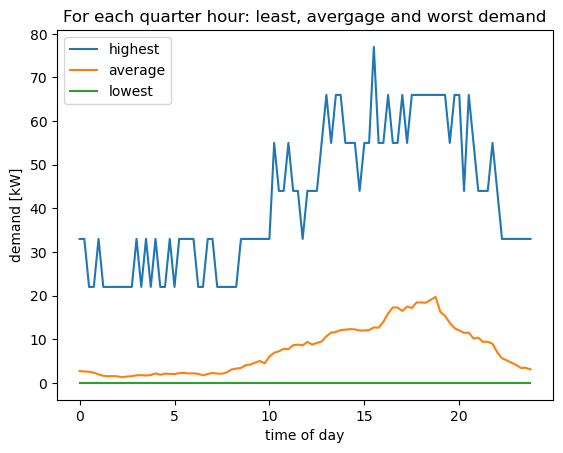

In [10]:

################################################################
#               First task
################################################################

results = simulation(probOneCarAppears, probDemand, nrDays, nrChargingPoints, powerPerStation_kW)



stationSumDemandsKw = np.sum(results["demandsKwh"], axis=0) / 0.25
stationSumDemandsKw_splitByDay = np.reshape(stationSumDemandsKw, (365, 24*4))
highestStationSumDemandKw = np.max(stationSumDemandsKw_splitByDay, axis=0)
averageStationSumDemandKw = np.mean(stationSumDemandsKw_splitByDay, axis=0)
lowestStationSumDemandKw = np.min(stationSumDemandsKw_splitByDay, axis=0)
times = [i/4 for i in range(24*4)]
plt.plot(times, highestStationSumDemandKw, label="highest")
plt.plot(times, averageStationSumDemandKw, label="average")
plt.plot(times, lowestStationSumDemandKw, label="lowest")
plt.title("For each quarter hour: least, avergage and worst demand")
plt.xlabel("time of day")
plt.ylabel("demand [kW]")
plt.legend()



The above graphic shows a summary of the 365 days of the simulated year. The orange line shows the quarter-hourly demand averaged over all 365 days.
The below output lists the required outputs for task 1.

In [11]:
{
    "totalEnergyConsumed": results["totalEnergyConsumed"], 
    "theoreticalMaxDemand": results["theoreticalMaxDemand"], 
    "actualMaxDemand": results["actualMaxDemand"], 
    "concurrencyFactor": results["concurrencyFactor"]
}

{'totalEnergyConsumed': 66321.75,
 'theoreticalMaxDemand': 220,
 'actualMaxDemand': 77.0,
 'concurrencyFactor': 0.35}

# Bonus Tasks

Text(0, 0.5, 'concurrency factor')

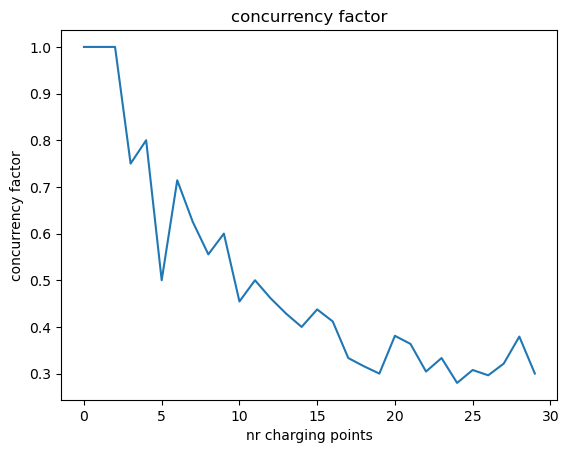

In [12]:

################################################################
#               BONUS
################################################################


# Run the program from task 1 for between 1 and 30 charge-points. How does the concurrency factor behave?
concurrencyFactors = []
for nrChargePoints in range(1, 31):
    results = simulation(probOneCarAppears, probDemand, nrDays, nrChargePoints, powerPerStation_kW)
    concurrencyFactors.append(results["concurrencyFactor"])

plt.plot(concurrencyFactors, label="concurrency factor (experimental)")
plt.title("concurrency factor")
plt.xlabel("nr charging points")
plt.ylabel("concurrency factor")




It's not surprising that the concurrency factor decreases with more charging points. 
Whereas with the first few charging points it was still moderately likely for all points to be occupied at the same time at least once a year, 
that probability decreases dramatically with more points. 

That result might be slightly different if cars can look for another spot if the first one is occupied. In real life one would have to investigate the possibility that the data in table T1 no longer holds for larger amounts of charging points. 

### If you consider the impact of DST vs. mapping the hours to the 15 minute ticks.
- We've already mentioned how our disaggregation of probabilities from one hour intervals to quarter-hour intervals assumes that the probability is not memory less.
- Accounting for DST can be done with the following changes:

```diff
    ###############  SIMULATION LOOP  #############################

    for time in range(nrDays * nrQuartHours):
        for chargingPoint in range(nrChargingPoints):

+           day = int(time / nrQuartHours)
            quartHour = time % nrQuartHours
+           dstDelta = formatAndGetDstDelta(day, quartHour)        # <------ checking whether currently DST

            
            # phase 1: car already there, or potentially new car arrives
            car = chargingPoints[chargingPoint]
            if car is None:
+               if np.random.rand() < probOneCarAppearsQuartHourly[(quartHour + dstDelta) % nrQuartHours]:    # <--- getting probabilities from offset position
                    car = Car()
            if car is None:
                continue

            # phase 2: car takes free spot
            chargingPoints[chargingPoint] = car

            # phase 3: car charges
            chargedKwh = car.charge(0.25, powerPerStation_kW)
+           demandsKwh[chargingPoint, time] = chargedKwh      # <---- we're _not_ letting DST affect the storage index of our results

            # phase 4: if car is done charging, it leaves the spot
            if car.isDone():
                chargingPoints[chargingPoint] = None
```

- This assumes that people do immediately adjust to DST, instead of needing a few days to adjust their habits. 
- An example implementation can be found in the file [simulation_with_dst.py](https://github.com/MichaelLangbein/reonic-demo/blob/main/task1/simulation_with_dst.py). The function `formatAndGetDstDelta` is shown below:

In [13]:
################# Example implementation of isDst #########################################


from datetime import datetime
import pytz
from pytz import NonExistentTimeError, AmbiguousTimeError



# adjusted from https://stackoverflow.com/questions/2881025/python-daylight-savings-time

def getDstDelta(date=None, timezone="UTC"):
    if date is None:
        date = datetime.utcnow()
    timezone = pytz.timezone(timezone)

    try:
        timezone_aware_date = timezone.localize(date, is_dst=None)
        isDst = timezone_aware_date.tzinfo._dst.seconds != 0
        if isDst:
            return -4
        else:
            return 0
    except NonExistentTimeError as e: 
        # Must be at end of DST (skipping an hour)
        return -4
    except AmbiguousTimeError as e:  
        # Must be at beginning of DST (re-doing an hour)
        return 0



def formatAndGetDstDelta(day, quartHour):
    year = 2024
    hour = str(int(quartHour / 4))
    if len(hour) == 1:
        hour = f"0{hour}"
    minutes = str((quartHour % 4) * 15)
    if len(minutes) == 1:
        minutes = f"0{minutes}"
    date = datetime.strptime(f"{year}-{day+1} {hour}:{minutes}", "%Y-%j %H:%M")

    delta = getDstDelta(date, "Europe/Berlin")
    return delta

### If you seed the probabilities vs. using random() for random-but-deterministic results.

- Seeding probabilities for the purpose of creating reproducible results would be detremimental to the process
- Since each simulation is but _one_ possible realization of a statistical process, seeding would cut off all but one possible realizations
- However: we _require_ those other processes to get a realistic impression of the spread of possible events
- Because after all, it is absolutely possible (though unlikely) that at one point in time 20 cars do arrive at the parking lot, all needing to charge
- Such an event is unlikely to be covered by a fxied (=seeded) realization of the simulation.
- One potential reason why one might want to seed probabilities is to reproduce a _design scenario_, a fixed scenario against which to design a structure. Commonly one would simply store the model's output, not the seed, though. Another would be to allow the user to refer back to a previous scenario.


# Side note: performance

It wasn't explicitly mentioned in the task description that performance should be a concern. But if we wanted to improve performance, some approaches spring to mind:


## Parallelizing

After the (very useful, thanks!) email exchange on the subject, we've now learned that `probOneCarAppears` is independent of the presence of cars at other charging points. 
With this knowledge, there seems be no shared memory between the different charging stations, meaning that we could easily **parallelize** the calculations - with simply one thread per charging point.

Also: if this were implemented in node, parallelization would probably best be implemented using [worker-threads](https://nodejs.org/api/worker_threads.html). 


## Efficient uncertainty estimation with unknown parameters: MCMC

We mentioned above how we can get an estimate of the uncertainty on our simulation results by employing a "Monte Carlo" approach, where we simply run the simulation several times and create histograms of the results, which should approximate the true probability distributions. 

This approach does, however, depend on us knowing the probability distrutions to sample from (Table T1 in this case). If that were not the case, for example if customer behavior were to change, one can infer those distributions from the data. A useful approach for this might be  **Markov Chain Monte Carlo**, (https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) which lets us sample from an _unknown_ distribution (as long as we have an expression for the likelihood $P(\theta | D)$, that is, an expression for the probability of the distributions parameters $\theta$ given the data $D$).

Full disclosure: this was actually the topic of my master-thesis, so I'm biased towards that approach here.